In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv("cleaned_movies_dataset.csv", encoding="latin1")

# Preview
df.head()

,Title,Language,Release_Date,Genres,Runtime,Director,Lead_Actors,IMDb_Rating,BMS_Rating,Avg_Rating
0,Sattham,Tamil,22/07/19,Thriller,154.0,Mani Shankar Iyer,Kamaal Lenin; Santhosh; Rohith Muralidharan; N...,8.8,8.5,8.65
1,Kaithi,Tamil,25/10/19,Action; Thriller,146.0,Lokesh Kanagaraj,Karthi; Narain; Arjun Das,8.4,8.9,8.65
2,KD (A) Karuppudurai,Tamil,27/06/19,Drama,123.0,Seenu Ramasamy,Karuppu; others,8.4,8.5,8.45
3,Asuran,Tamil,04/10/19,Action; Drama,141.0,Vetrimaaran,Dhanush; Manju Warrier,8.4,8.3,8.35
4,Kurukshetra 3D,Tamil,08/03/19,Historical; War,135.0,Nagana,Yogesh Kumar; Gayathrie,8.4,8.0,8.20


#### Q6: How has the average runtime of South Indian films evolved (2019–2025), and what correlations exist between runtime, genre, and ratings?
#### Plot 1: Boxplot of runtime by top genres.  
#### Plot 2: Line chart of average runtime by language.  

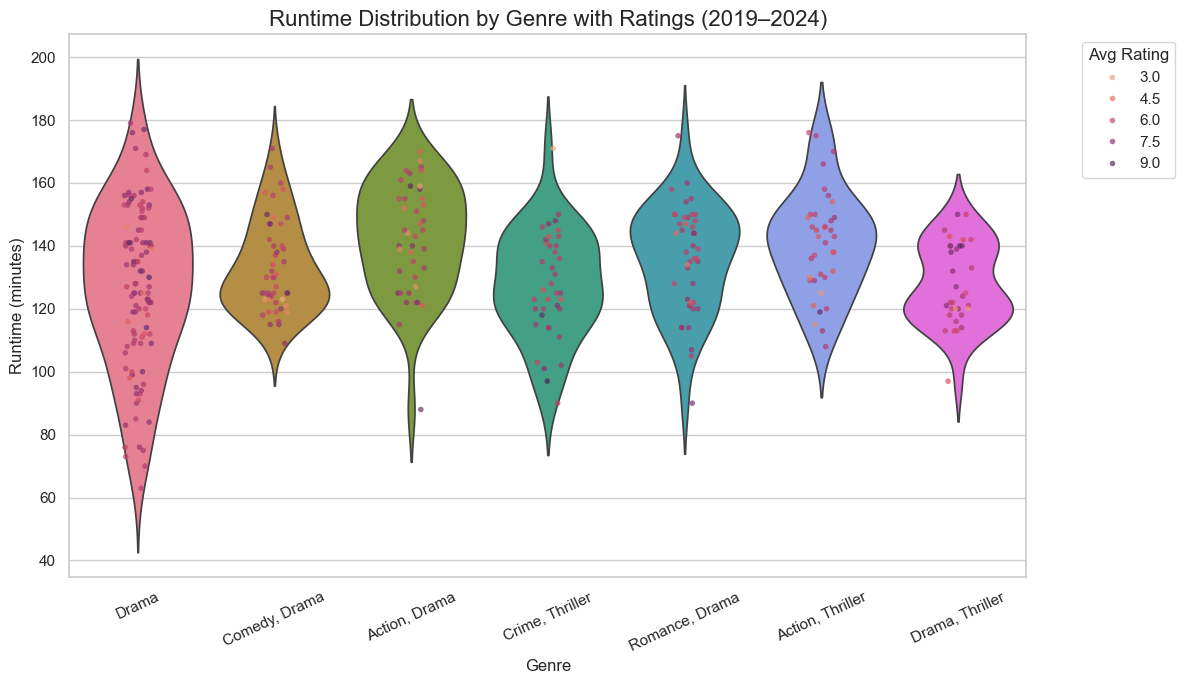

In [12]:
# --- Data Preparation ---
df['Release_Date'] = pd.to_datetime(df['Release_Date'], errors='coerce', dayfirst=True)
df['Year'] = df['Release_Date'].dt.year
df = df.dropna(subset=['Runtime', 'Avg_Rating', 'Genres'])
df = df[df['Year'].between(2019, 2025)]

# Split and explode genres
df['Genres'] = df['Genres'].astype(str).str.split(';')
df = df.explode('Genres')
df['Genres'] = df['Genres'].str.strip()

# Keep top 7 genres
top_genres = df['Genres'].value_counts().nlargest(7).index.tolist()
df_top = df[df['Genres'].isin(top_genres)]

plt.figure(figsize=(12, 7))
sns.violinplot(data=df_top, x='Genres', y='Runtime', inner=None, palette='husl')
sns.stripplot(data=df_top, x='Genres', y='Runtime', hue='Avg_Rating',
              palette='flare', dodge=False, size=4, alpha=0.7)

plt.title("Runtime Distribution by Genre with Ratings (2019–2024)", fontsize=16)
plt.xlabel("Genre", fontsize=12)
plt.ylabel("Runtime (minutes)", fontsize=12)
plt.xticks(rotation=25)
plt.legend(title="Avg Rating", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

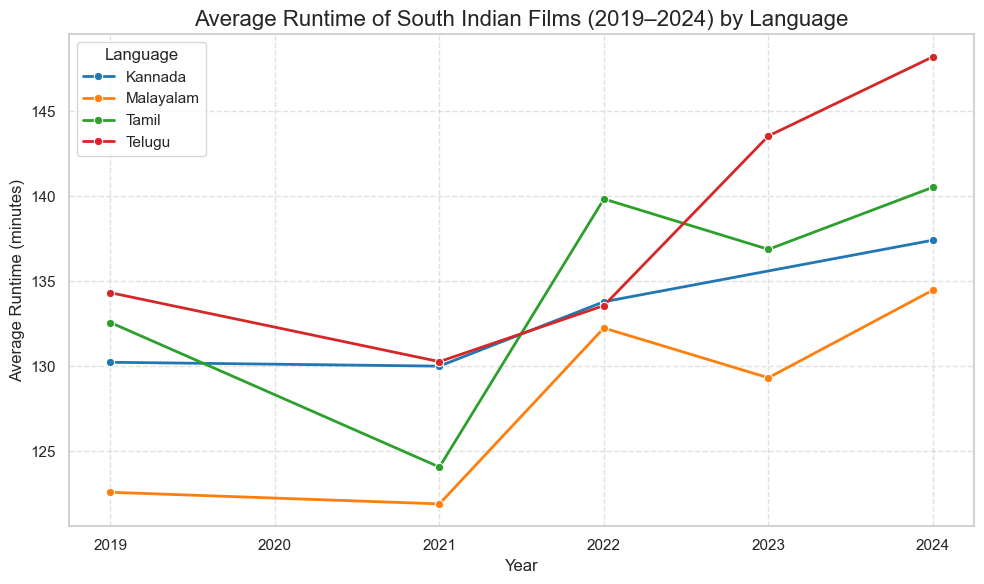

In [13]:
df_lang = df.dropna(subset=['Runtime', 'Language'])

# Group by Year & Language
yearly_runtime = df_lang.groupby(['Year', 'Language'])['Runtime'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=yearly_runtime, x='Year', y='Runtime', hue='Language',
             marker='o', linewidth=2, palette="tab10", ci="sd")

plt.title("Average Runtime of South Indian Films (2019–2024) by Language", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Average Runtime (minutes)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


#### Q7: How do IMDb and BookMyShow ratings align across genres, languages, and years, and what outliers/discrepancies appear?

#### Plot 1: Diverging Bar Chart (by Genre)

#### Plot 2: Heatmap (by Year & Language)

#### Plot 3: Hexbin Density Plot (IMDb vs BMS Ratings)

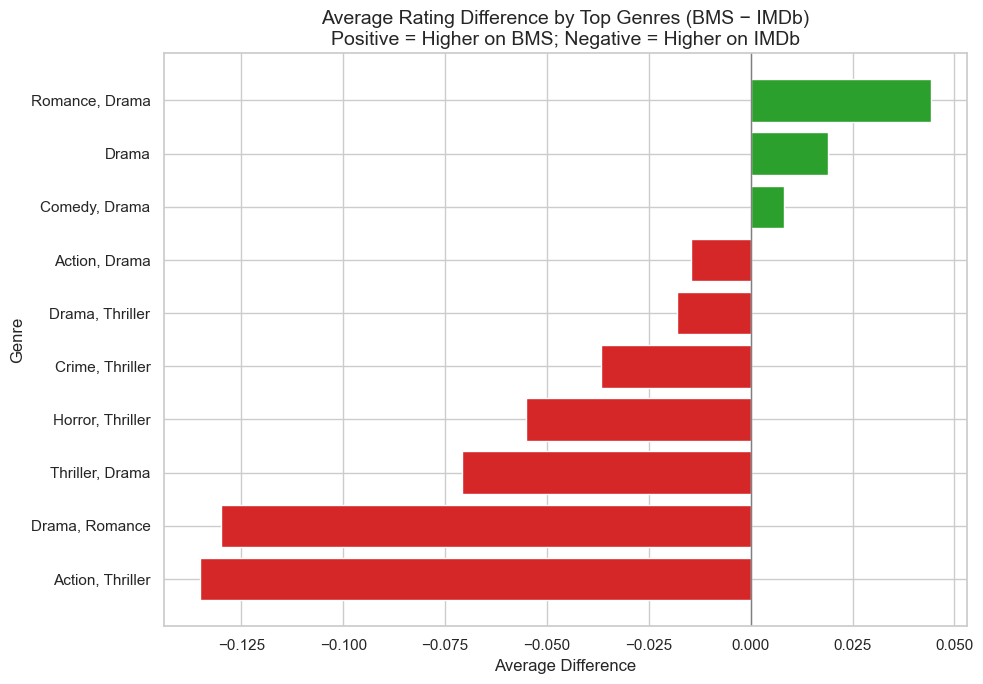

In [14]:
df['Release_Date'] = pd.to_datetime(df['Release_Date'], errors='coerce', dayfirst=True)
df['Year'] = df['Release_Date'].dt.year
df = df[df['Year'].between(2019, 2025)]

df_genre = df.dropna(subset=['IMDb_Rating', 'BMS_Rating', 'Genres']).copy()

# Split and explode genres
df_genre['Genres'] = df_genre['Genres'].astype(str).str.split(';')
df_genre = df_genre.explode('Genres')
df_genre['Genres'] = df_genre['Genres'].str.strip()
df_genre = df_genre[df_genre['Genres'] != '']

# Compute difference
df_genre['Diff_BMS_minus_IMDb'] = df_genre['BMS_Rating'] - df_genre['IMDb_Rating']

# Top 10 genres by frequency
top_genres = df_genre['Genres'].value_counts().nlargest(10).index.tolist()
g = (df_genre[df_genre['Genres'].isin(top_genres)]
     .groupby('Genres')['Diff_BMS_minus_IMDb']
     .mean()
     .sort_values())

plt.figure(figsize=(10, 7))
sns.set_theme(style="whitegrid")
colors = ['tab:red' if val < 0 else 'tab:green' for val in g.values]
bars = plt.barh(g.index, g.values, color=colors)

plt.axvline(0, color="gray", linewidth=1)
plt.title("Average Rating Difference by Top Genres (BMS − IMDb)\nPositive = Higher on BMS; Negative = Higher on IMDb", fontsize=14)
plt.xlabel("Average Difference", fontsize=12)
plt.ylabel("Genre", fontsize=12)

plt.tight_layout()
plt.show()

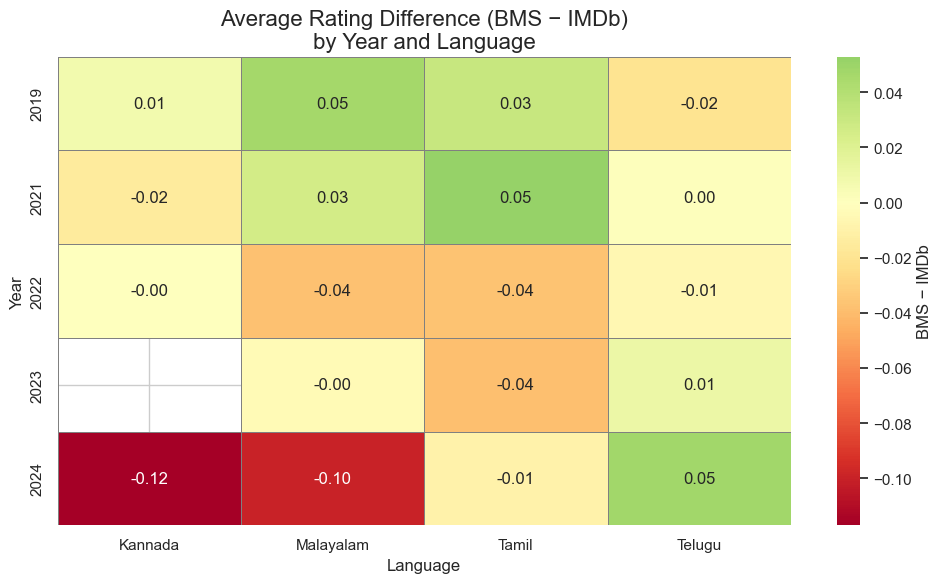

In [15]:
df_lang = df.dropna(subset=['IMDb_Rating', 'BMS_Rating', 'Language']).copy()
df_lang['Diff_BMS_minus_IMDb'] = df_lang['BMS_Rating'] - df_lang['IMDb_Rating']

heatmap_data = df_lang.pivot_table(
    index="Year", columns="Language",
    values="Diff_BMS_minus_IMDb",
    aggfunc="mean"
)

plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_data, cmap="RdYlGn", center=0,
    annot=True, fmt=".2f", linewidths=0.5, linecolor="gray", cbar_kws={'label': 'BMS − IMDb'}
)

plt.title("Average Rating Difference (BMS − IMDb)\nby Year and Language", fontsize=16)
plt.xlabel("Language", fontsize=12)
plt.ylabel("Year", fontsize=12)
plt.tight_layout()
plt.show()


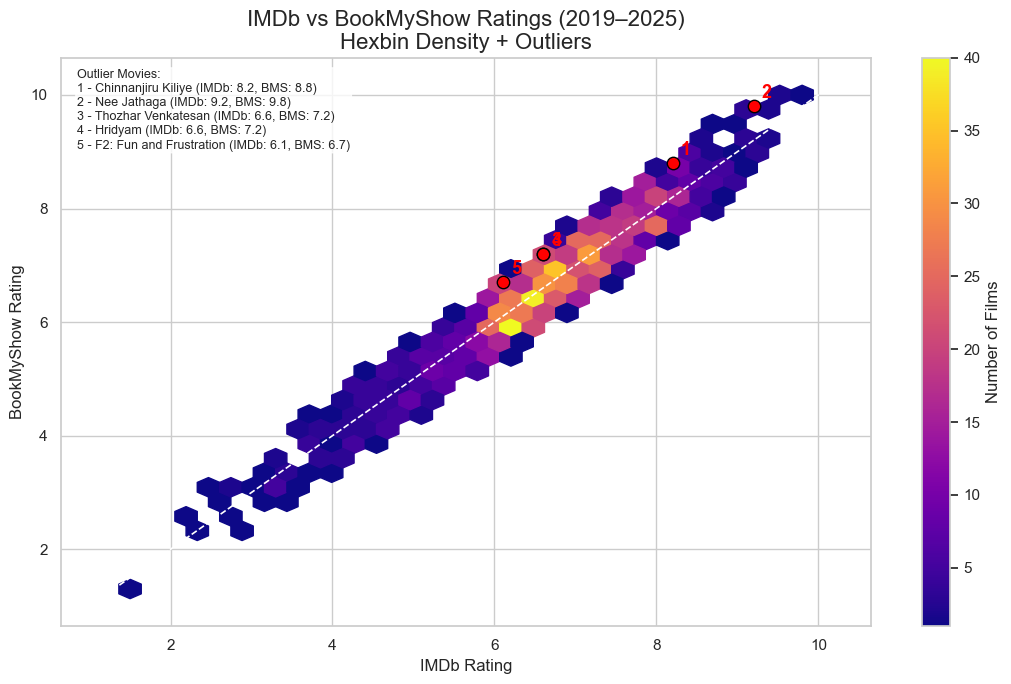

In [16]:
import textwrap

df_ratings = df.dropna(subset=['IMDb_Rating', 'BMS_Rating', 'Title']).copy()

plt.figure(figsize=(11, 7))
hb = plt.hexbin(
    df_ratings['IMDb_Rating'], df_ratings['BMS_Rating'],
    gridsize=30, cmap="plasma", mincnt=1
)

cb = plt.colorbar(hb)
cb.set_label("Number of Films")

# Diagonal reference line
lims = [min(df_ratings['IMDb_Rating'].min(), df_ratings['BMS_Rating'].min()) - 0.2,
        max(df_ratings['IMDb_Rating'].max(), df_ratings['BMS_Rating'].max()) + 0.2]
plt.plot(lims, lims, linestyle="--", color="white", linewidth=1.2)

# Find biggest mismatches
df_ratings['Diff'] = (df_ratings['BMS_Rating'] - df_ratings['IMDb_Rating']).abs()
outliers = df_ratings.nlargest(5, 'Diff')  # Top 5 mismatches
plt.scatter(outliers['IMDb_Rating'], outliers['BMS_Rating'],
            color="red", edgecolor="black", s=80, zorder=5)

# Build outlier list for text box
outlier_labels = []
for i, row in enumerate(outliers.itertuples(), 1):
    label = f"{i} - {row.Title} (IMDb: {row.IMDb_Rating}, BMS: {row.BMS_Rating})"
    wrapped_label = "\n".join(textwrap.wrap(label, width=50))
    outlier_labels.append(wrapped_label)

# Place outlier list inside plot (top-left)
plt.gca().text(
    0.02, 0.98,
    "Outlier Movies:\n" + "\n".join(outlier_labels),
    transform=plt.gca().transAxes,
    fontsize=9, va="top", ha="left",
    bbox=dict(boxstyle="round,pad=0.1", facecolor="white", alpha=0.8)
)

# Annotate each outlier point with its number
for i, row in enumerate(outliers.itertuples(), 1):
    plt.annotate(
        str(i),
        (row.IMDb_Rating, row.BMS_Rating),
        textcoords="offset points",
        xytext=(6, 6),   # offset to avoid overlap with the dot
        ha="left", fontsize=13, weight="bold", color="red"
    )

plt.title("IMDb vs BookMyShow Ratings (2019–2025)\nHexbin Density + Outliers", fontsize=16)
plt.xlabel("IMDb Rating", fontsize=12)
plt.ylabel("BookMyShow Rating", fontsize=12)
plt.tight_layout()
plt.show()

### Q8: Which combinations of genre, language, and runtime receive the highest audience approval, and what traits define these films?

#### Plot 1: Bubble Plot (Genre × Language)

#### Plot 2: Heatmap (Avg Rating + Runtime)



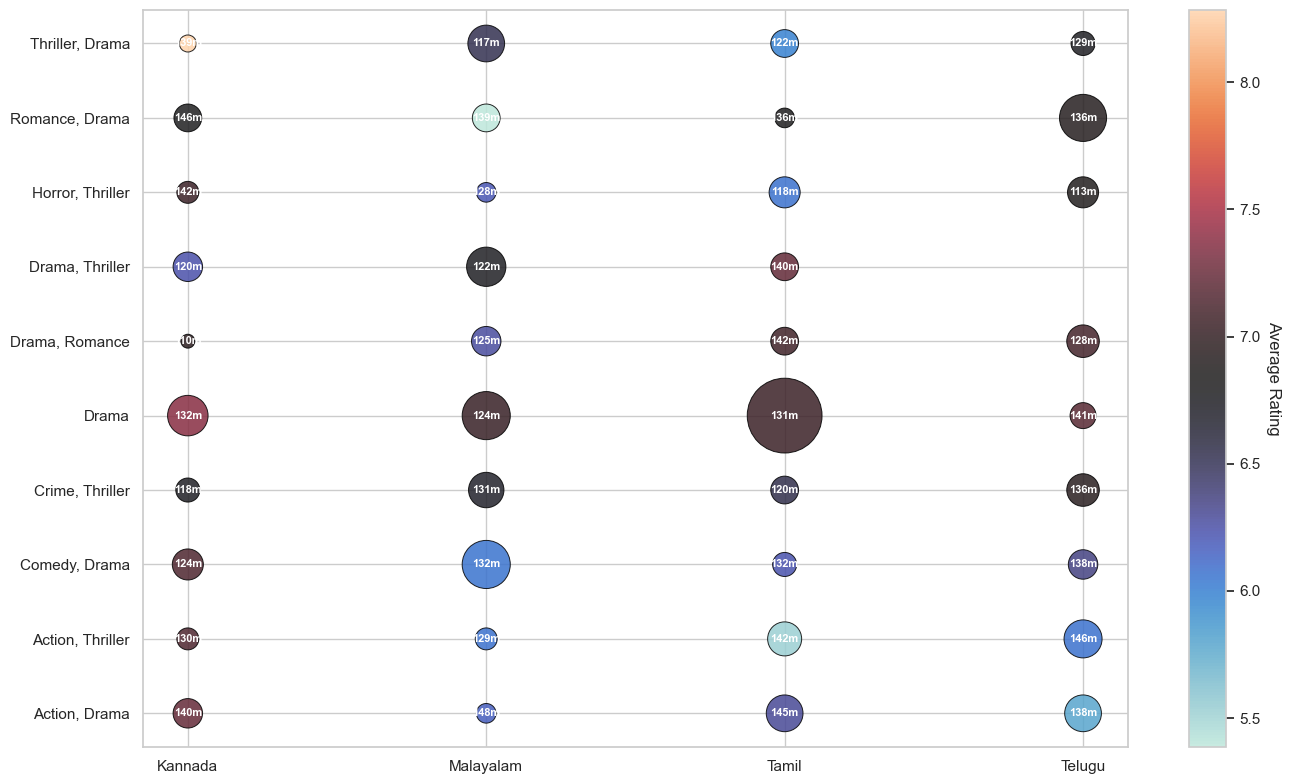

In [17]:
df_bubble = df.copy()
df_bubble['Genres'] = df_bubble['Genres'].astype(str).str.split(r';\s*', regex=True)
df_bubble = df_bubble.explode('Genres')
df_bubble['Genres'] = df_bubble['Genres'].str.strip()
df_bubble = df_bubble[df_bubble['Genres'] != '']

# Limit to top 10 genres
top_genres = df_bubble['Genres'].value_counts().nlargest(10).index.tolist()
df_bubble = df_bubble[df_bubble['Genres'].isin(top_genres)]

# Aggregate
agg = (df_bubble.groupby(['Genres', 'Language'])
         .agg(Avg_Rating=('Avg_Rating', 'mean'),
              Count=('Title', 'count'),
              Runtime_Median=('Runtime', 'median'))
         .reset_index())

agg['BubbleSize'] = agg['Count'] * 50

plt.figure(figsize=(14, 8))
sns.set_theme(style="whitegrid")

scatter = plt.scatter(
    x=agg['Language'], y=agg['Genres'],
    s=agg['BubbleSize'],
    c=agg['Avg_Rating'],
    cmap='icefire', alpha=0.85, edgecolors='black', linewidths=0.7
)

# Annotate runtime inside bubbles
for _, row in agg.iterrows():
    plt.text(row['Language'], row['Genres'], f"{int(round(row['Runtime_Median']))}m",
             ha='center', va='center', fontsize=8, color='white', weight='bold')


# Colorbar
cbar = plt.colorbar(scatter)
cbar.set_label("Average Rating", rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

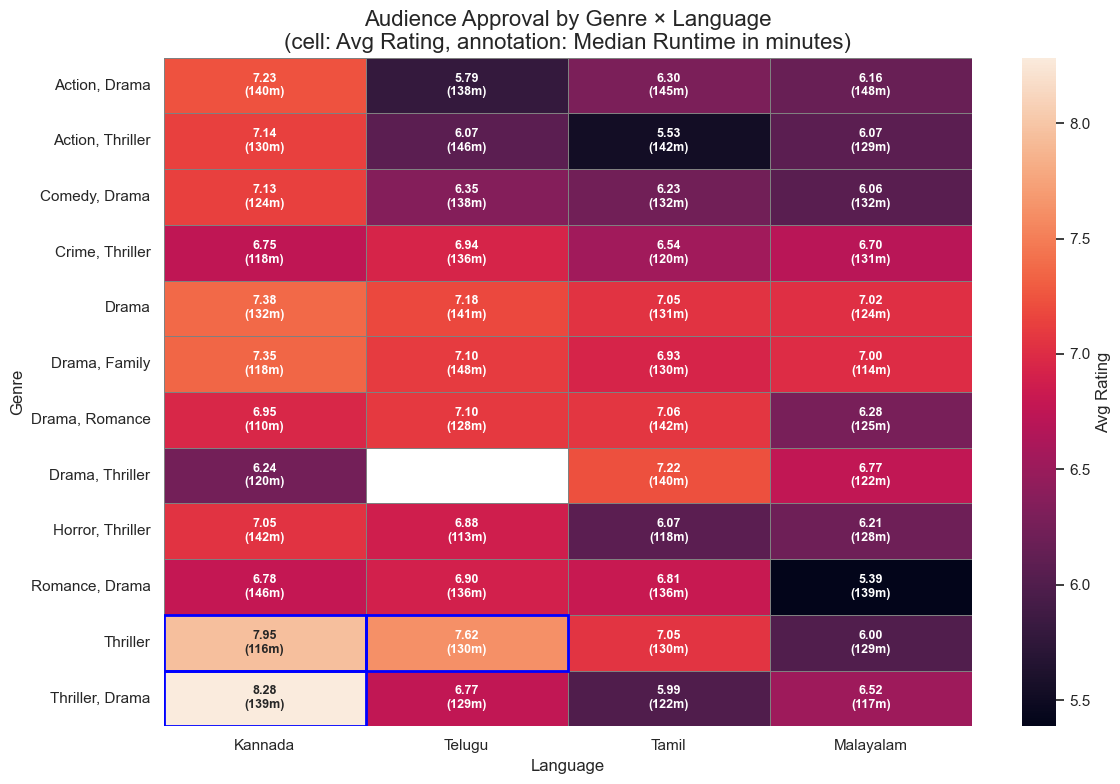

In [18]:
df_heat = df.copy()
df_heat['Genres'] = df_heat['Genres'].astype(str).str.split(r';\s*', regex=True)
df_heat = df_heat.explode('Genres')
df_heat['Genres'] = df_heat['Genres'].str.strip()
df_heat = df_heat[df_heat['Genres'] != '']

# Top 12 genres
top_genres = df_heat['Genres'].value_counts().nlargest(12).index.tolist()
df_heat = df_heat[df_heat['Genres'].isin(top_genres)]

# Aggregations
agg_rating = (df_heat.groupby(['Genres', 'Language'])['Avg_Rating']
                .mean()
                .reset_index(name='Avg_Rating'))
agg_runtime = (df_heat.groupby(['Genres', 'Language'])['Runtime']
                 .median()
                 .reset_index(name='Runtime_Median'))
agg = pd.merge(agg_rating, agg_runtime, on=['Genres', 'Language'], how='outer')

# Pivot
heat = agg.pivot(index='Genres', columns='Language', values='Avg_Rating')
run = agg.pivot(index='Genres', columns='Language', values='Runtime_Median')

# Annotations (rating + runtime)
annot = heat.copy().astype(str)
for i in heat.index:
    for j in heat.columns:
        rating = heat.loc[i, j]
        runtime = run.loc[i, j]
        if pd.isna(rating):
            annot.loc[i, j] = ''
        else:
            annot.loc[i, j] = f"{rating:.2f}\n({int(round(runtime))}m)" if not pd.isna(runtime) else f"{rating:.2f}"

# Sort languages by overall Avg Rating
lang_order = agg.groupby('Language')['Avg_Rating'].mean().sort_values(ascending=False).index
heat = heat[lang_order]
annot = annot[lang_order]

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.set_theme(style="white")
ax = sns.heatmap(
    heat, cmap="rocket",
    vmin=heat.min().min(), vmax=heat.max().max(),
    annot=annot, fmt="", annot_kws={"size":9, "weight":"bold"},
    linewidths=0.5, linecolor="gray",
    cbar_kws={"label": "Avg Rating"}
)

# --- Highlight top 3 cells ---
top3 = agg.nlargest(3, 'Avg_Rating')
for _, row in top3.iterrows():
    g = list(heat.index).index(row['Genres'])
    l = list(heat.columns).index(row['Language'])
    ax.add_patch(plt.Rectangle((l, g), 1, 1, fill=False, edgecolor='blue', lw=2))

plt.title("Audience Approval by Genre × Language\n(cell: Avg Rating, annotation: Median Runtime in minutes)", fontsize=16)
plt.xlabel("Language", fontsize=12)
plt.ylabel("Genre", fontsize=12)
plt.tight_layout()
plt.show()

### Q9: How do genre popularity and average audience ratings vary across languages and years; which clusters dominate 2019–2025?

#### Plot 1: Bar + Line Combo (Film Count vs Avg Rating by Genre)

#### Plot 2: Smoothed Line Chart (Avg Ratings by Genre Over Years)

#### Plot 3: Stacked Area Chart (Genre Popularity Over Time)

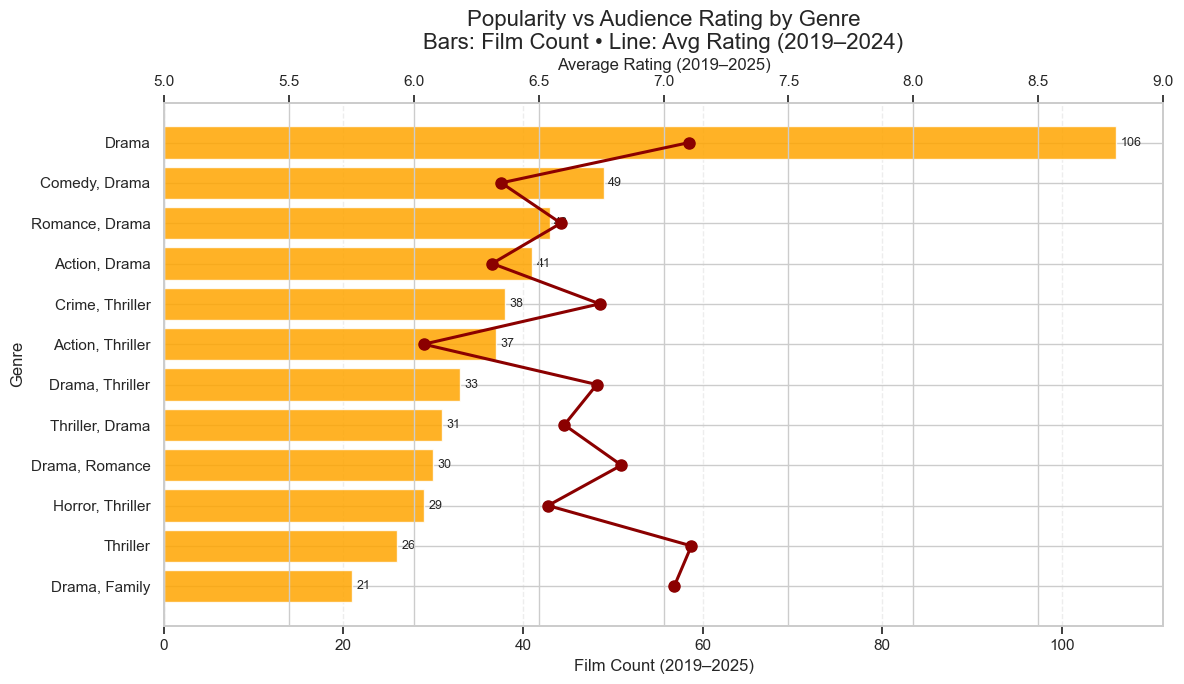

In [19]:
df['Release_Date'] = pd.to_datetime(df['Release_Date'], errors='coerce', dayfirst=True)
df['Year'] = df['Release_Date'].dt.year
df = df[df['Year'].between(2019, 2025)]

df_barline = df.dropna(subset=['Genres', 'Avg_Rating']).copy()

# Explode genres
df_barline['Genres'] = df_barline['Genres'].astype(str).str.split(r';\s*', regex=True)
df_barline = df_barline.explode('Genres')
df_barline['Genres'] = df_barline['Genres'].str.strip()
df_barline = df_barline[df_barline['Genres'] != '']

# Aggregate
agg = (df_barline.groupby('Genres')
         .agg(Film_Count=('Title', 'count'),
              Avg_Rating=('Avg_Rating', 'mean'))
         .reset_index())

# Top 12 genres by film count
agg = agg.sort_values('Film_Count', ascending=False).head(12)
agg = agg.sort_values('Film_Count', ascending=True)

# Plot
sns.set_theme(style='whitegrid')
fig, ax1 = plt.subplots(figsize=(12, 7))
x = np.arange(len(agg))
bars = ax1.barh(
    x, agg['Film_Count'],
    color="orange",   # <- choose any matplotlib color name or hex code
    alpha=0.85
)


ax1.set_xlabel("Film Count (2019–2025)")
ax1.set_ylabel("Genre")
ax1.set_yticks(x, agg['Genres'])
ax1.grid(True, axis="x", linestyle="--", alpha=0.35)

# Annotate bar values
for b in bars:
    ax1.text(b.get_width() + 0.5, b.get_y() + b.get_height()/2,
             f"{int(b.get_width())}", va="center", fontsize=9)

# Twin axis for ratings
ax2 = ax1.twiny()
ax2.plot(
    agg['Avg_Rating'], x,
    marker="o", markersize=8,
    color="darkred",   # <- line color
    linewidth=2.2
)
ax2.set_xlabel("Average Rating (2019–2025)")
ax2.set_xlim(5, 9)
ax2.set_xticks(np.arange(5, 9.1, 0.5))

plt.title("Popularity vs Audience Rating by Genre\nBars: Film Count • Line: Avg Rating (2019–2024)", fontsize=16)
plt.tight_layout()
plt.show()


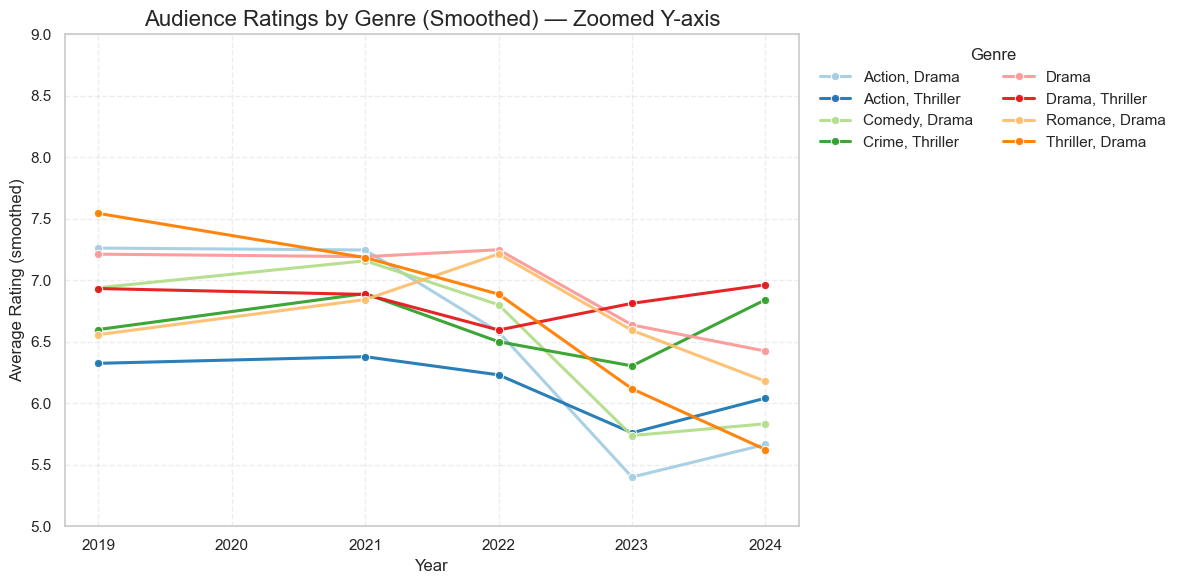

In [20]:
df_line = df.dropna(subset=['Genres', 'Language', 'Avg_Rating']).copy()

# Explode genres
df_line['Genres'] = df_line['Genres'].astype(str).str.split(r';\s*', regex=True)
df_line = df_line.explode('Genres')
df_line['Genres'] = df_line['Genres'].str.strip()
df_line = df_line[df_line['Genres'] != '']

# Limit to top 8 genres
top_genres = df_line['Genres'].value_counts().nlargest(8).index.tolist()
df_line = df_line[df_line['Genres'].isin(top_genres)]

# Aggregate ratings by Year × Genre
rating_trend = (df_line.groupby(['Year', 'Genres'])['Avg_Rating']
                  .mean()
                  .reset_index())

# Smooth with rolling mean
rating_trend = rating_trend.sort_values(['Genres', 'Year']).reset_index(drop=True)
rating_trend['Avg_Rating_Smoothed'] = (rating_trend
                                       .groupby('Genres')['Avg_Rating']
                                       .transform(lambda s: s.rolling(window=2, min_periods=1).mean()))

# Plot
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))
ax = sns.lineplot(
    data=rating_trend, x="Year", y="Avg_Rating_Smoothed", hue="Genres",
    estimator=None, lw=2.2, marker="o", ci=None, alpha=0.95, palette="Paired"
)

ax.set_title("Audience Ratings by Genre (Smoothed) — Zoomed Y-axis", fontsize=16)
ax.set_xlabel("Year")
ax.set_ylabel("Average Rating (smoothed)")
ax.set_ylim(5, 9)
ax.set_yticks(np.arange(5, 9.1, 0.5))
ax.grid(True, linestyle="--", alpha=0.35)
ax.legend(title="Genre", ncol=2, loc="upper left", bbox_to_anchor=(1.01, 1.0), frameon=False)

plt.tight_layout()
plt.show()

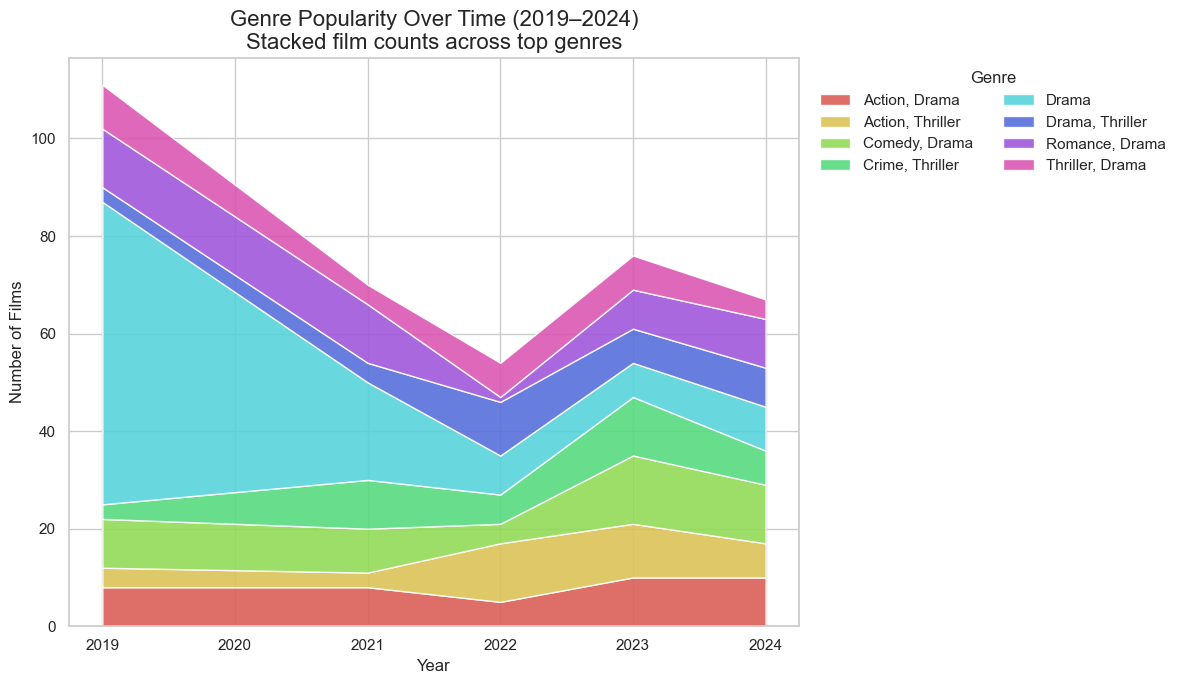

In [21]:
df_area = df.dropna(subset=['Genres', 'Language', 'Runtime', 'Avg_Rating']).copy()

# Explode genres
df_area['Genres'] = df_area['Genres'].astype(str).str.split(r';\s*', regex=True)
df_area = df_area.explode('Genres')
df_area['Genres'] = df_area['Genres'].str.strip()
df_area = df_area[df_area['Genres'] != '']

# Limit to top 8 genres
top_genres = df_area['Genres'].value_counts().nlargest(8).index.tolist()
df_area = df_area[df_area['Genres'].isin(top_genres)]

# Popularity by Year × Genre
counts = (df_area.groupby(['Year', 'Genres'])['Title']
            .count()
            .reset_index(name='Film_Count'))

# Pivot for stackplot
wide = counts.pivot(index='Year', columns='Genres', values='Film_Count').fillna(0)
wide = wide.sort_index()

# Plot stacked area
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 7))
genres_order = list(wide.columns)
x = wide.index.values
y = [wide[g].values for g in genres_order]

colours = sns.color_palette("hls", n_colors=len(genres_order))
plt.stackplot(x, y, labels=genres_order, alpha=0.9, colors=colours)
plt.title("Genre Popularity Over Time (2019–2024)\nStacked film counts across top genres", fontsize=16)
plt.xlabel("Year"); plt.ylabel("Number of Films")
plt.legend(title="Genre", ncol=2, loc="upper left", bbox_to_anchor=(1.01, 1.0), frameon=False)
plt.tight_layout()
plt.show()


### Q10: Which directors consistently produce critically appreciated movies, and how do their works differ by language and runtime?

#### Plot 1: Bar Ranking (Consistency Score by Director)  

#### Plot 2: Box + Strip Plot (Runtime Profiles by Director)


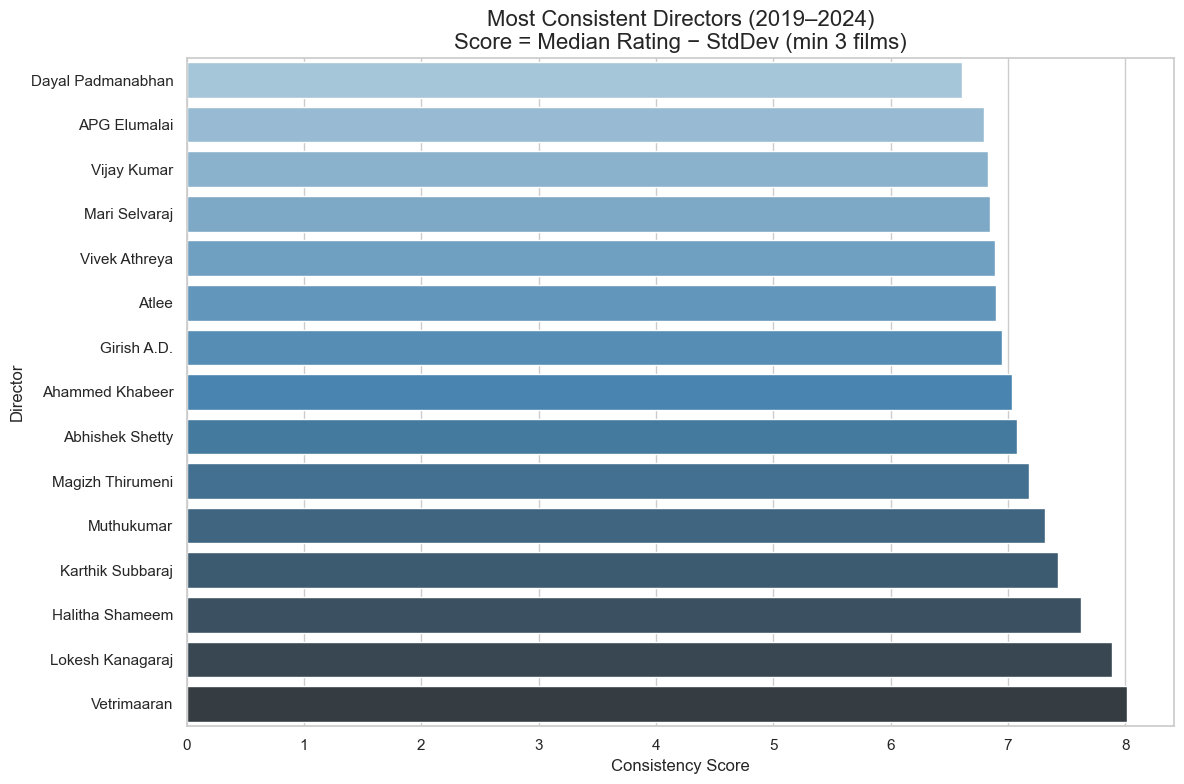

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data
df['Release_Date'] = pd.to_datetime(df['Release_Date'], errors='coerce', dayfirst=True)
df['Year'] = df['Release_Date'].dt.year
df_filtered = df[df['Year'].between(2019, 2025)]

df_consistency = df_filtered.dropna(subset=['Director', 'Avg_Rating']).copy()
stats = (df_consistency.groupby('Director')['Avg_Rating']
         .agg(['count', 'median', 'std'])
         .rename(columns={'count':'Film_Count','median':'Median_Rating','std':'StdDev'})
         .reset_index())
stats = stats[stats['Film_Count'] >= 3].copy()
stats['StdDev'] = stats['StdDev'].fillna(0.0)
stats['Consistency_Score'] = stats['Median_Rating'] - stats['StdDev']
stats = stats.sort_values(['Consistency_Score','Film_Count'], ascending=[False, False]).head(15)
stats = stats.sort_values('Consistency_Score', ascending=True)

# Plotting
sns.set_theme(style='whitegrid')
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=stats, x='Consistency_Score', y='Director', palette='Blues_d')

ax.set_title("Most Consistent Directors (2019–2024)\nScore = Median Rating − StdDev (min 3 films)", fontsize=16)
ax.set_xlabel("Consistency Score", fontsize=12)
ax.set_ylabel("Director", fontsize=12)

plt.tight_layout()
plt.show()

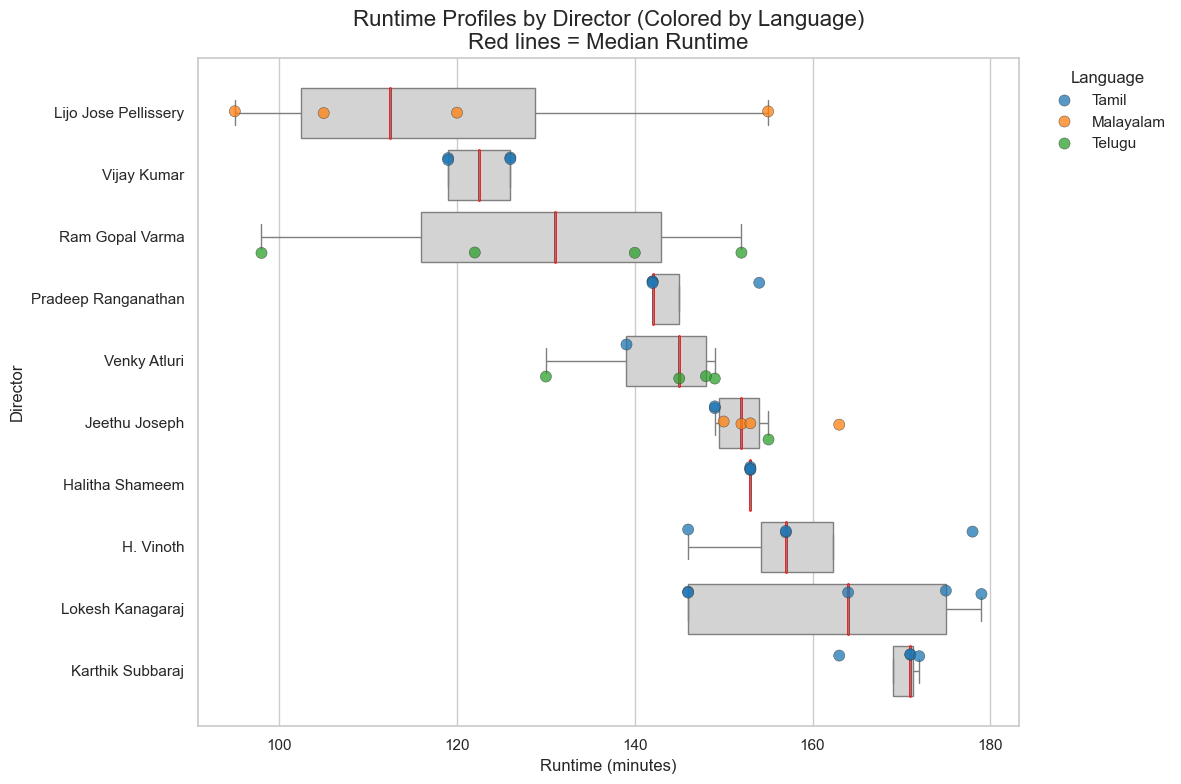

In [23]:
# Prepare data
df_runtime = df_filtered.dropna(subset=['Director', 'Runtime', 'Language']).copy()
dir_counts = df_runtime['Director'].value_counts()
keep_dirs = dir_counts[dir_counts >= 3].head(10).index.tolist()
df_runtime = df_runtime[df_runtime['Director'].isin(keep_dirs)]
order = (df_runtime.groupby('Director')['Runtime'].median().sort_values()).index.tolist()

# Plotting
sns.set_theme(style='whitegrid')
plt.figure(figsize=(12, 8))
ax = sns.boxplot(data=df_runtime, x='Runtime', y='Director', order=order, fliersize=0, color='lightgray')

# Add stripplot
sns.stripplot(data=df_runtime, x='Runtime', y='Director', order=order, hue='Language',
              dodge=True, alpha=0.75, size=8, linewidth=0.4, palette="tab10")

# Overlay median runtime lines
medians = df_runtime.groupby('Director')['Runtime'].median()
for i, director in enumerate(order):
    median = medians[director]
    ax.plot([median, median], [i - 0.4, i + 0.4], color='red', linewidth=2)

ax.set_title("Runtime Profiles by Director (Colored by Language)\nRed lines = Median Runtime", fontsize=16)
ax.set_xlabel("Runtime (minutes)", fontsize=12)
ax.set_ylabel("Director", fontsize=12)

# Move legend outside
handles, labels = ax.get_legend_handles_labels()
if labels:
    ax.legend(title="Language", bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)

plt.tight_layout()
plt.show()